In [ ]:
!pip install -q spacy torch torchvision torchaudio scikit-learn pandas numpy matplotlib wordcloud
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Preprocessing text (this may take a few minutes)...

--- Task 1: Product Category Classification ---
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
                              precision    recall  f1-score   support

                     Books_5       0.73      0.62      0.67       915
Clothing_Shoes_and_Jewelry_5       0.74      0.75      0.75       746
               Electronics_5       0.71      0.75      0.73       760
          Home_and_Kitchen_5       0.63      0.58      0.60       847
              Kindle_Store_5       0

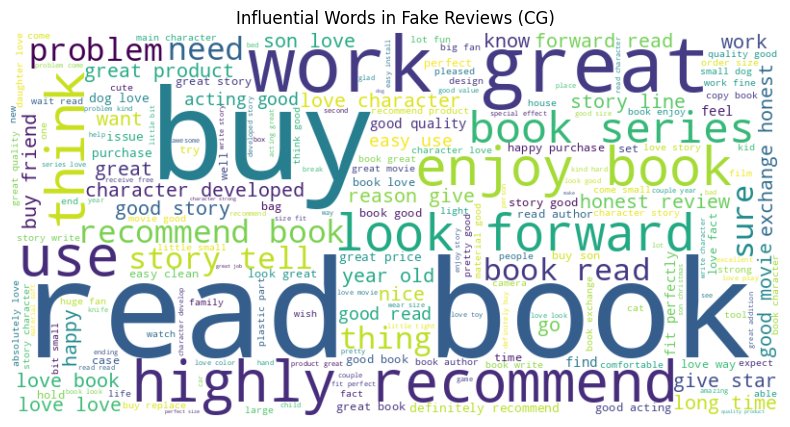

In [ ]:

!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


df = pd.read_csv('fake_reviews_dataset.csv')


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    doc = nlp(str(text).lower())

    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip()]
    return tokens

print("Preprocessing text (this may take a few minutes)...")
df['tokens'] = df['text_'].apply(preprocess_text)


all_tokens = [t for tokens in df['tokens'] for t in tokens]
vocab_freq = Counter(all_tokens)

vocab = {word: i+1 for i, (word, count) in enumerate(vocab_freq.most_common(10000))}
vocab['<UNK>'] = 0
vocab_size = len(vocab)

def text_to_indices(tokens):
    return [vocab.get(t, 0) for t in tokens]

df['indices'] = df['tokens'].apply(text_to_indices)


class ReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths) if max(lengths) > 0 else 1
    padded_seqs = torch.zeros(len(sequences), max_len, dtype=torch.long)
    for i, seq in enumerate(sequences):
        if len(seq) > 0:
            padded_seqs[i, :len(seq)] = seq
    return padded_seqs.to(device), torch.stack(labels).to(device)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        return self.fc(hidden[-1])

print("\n--- Task 1: Product Category Classification ---")
le_cat = LabelEncoder()
df['cat_label'] = le_cat.fit_transform(df['category'])

X_train, X_test, y_train, y_test = train_test_split(df['indices'], df['cat_label'], test_size=0.2, random_state=42)
train_loader = DataLoader(ReviewDataset(X_train.tolist(), y_train.tolist()), batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ReviewDataset(X_test.tolist(), y_test.tolist()), batch_size=32, shuffle=False, collate_fn=collate_fn)

model_cat = GRUClassifier(vocab_size, 100, 128, len(le_cat.classes_)).to(device)
optimizer = optim.Adam(model_cat.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


for epoch in range(5):
    model_cat.train()
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cat(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed.")


model_cat.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model_cat(texts)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=le_cat.classes_))

print("\n--- Task 2: Fake Review Detection ---")
le_fake = LabelEncoder()
df['fake_label'] = le_fake.fit_transform(df['label']) # CG=0 (Fake), OR=1 (Genuine)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(df['indices'], df['fake_label'], test_size=0.2, random_state=42)
train_loader_f = DataLoader(ReviewDataset(X_train_f.tolist(), y_train_f.tolist()), batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader_f = DataLoader(ReviewDataset(X_test_f.tolist(), y_test_f.tolist()), batch_size=32, shuffle=False, collate_fn=collate_fn)

model_fake = GRUClassifier(vocab_size, 100, 128, 2).to(device)
optimizer_f = optim.Adam(model_fake.parameters(), lr=0.001)

for epoch in range(5):
    model_fake.train()
    for texts, labels in train_loader_f:
        optimizer_f.zero_grad()
        outputs = model_fake(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_f.step()

model_fake.eval()
yf_pred, yf_true = [], []
with torch.no_grad():
    for texts, labels in test_loader_f:
        outputs = model_fake(texts)
        preds = torch.argmax(outputs, dim=1)
        yf_pred.extend(preds.cpu().numpy())
        yf_true.extend(labels.cpu().numpy())

print(classification_report(yf_true, yf_pred, target_names=le_fake.classes_))

fake_reviews_text = " ".join([" ".join(tokens) for tokens in df[df['label'] == 'CG']['tokens']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_reviews_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Influential Words in Fake Reviews (CG)')
plt.show()